In [15]:
library(tidyverse)
library(caret)
library(lattice)
library(dygraphs)
library(cowplot)
library(ggthemr)

ggthemr::ggthemr("fresh")

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

## What value do the zones add?

### For regression

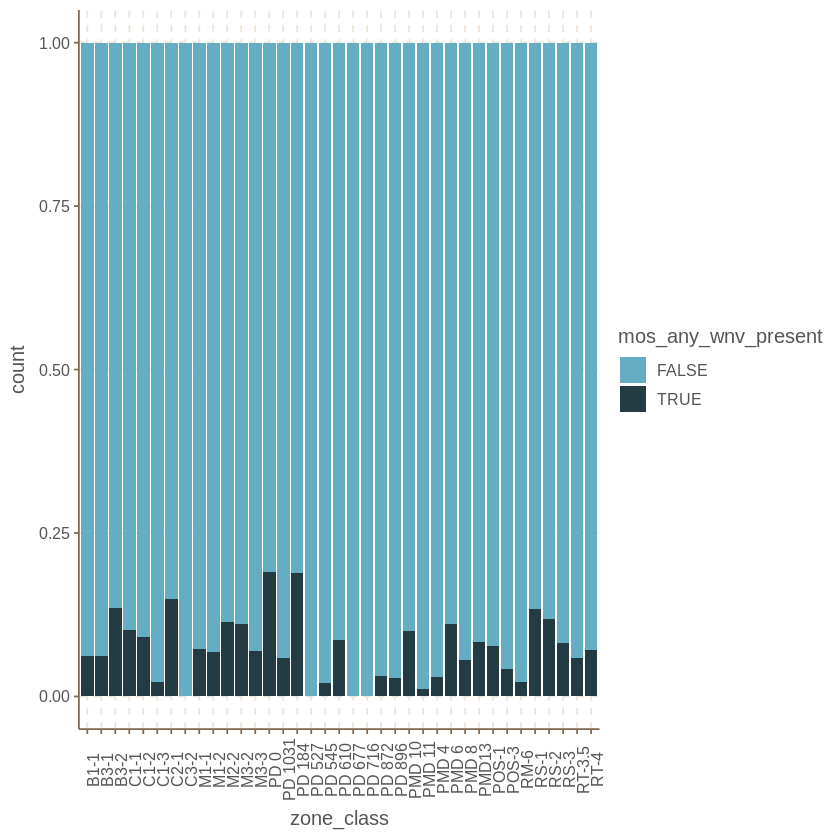

In [17]:
df_train %>% ggplot(aes(fill=mos_any_wnv_present,zone_class)) +
    geom_bar(position="fill")+theme(axis.text.x = element_text(angle=90))

## For classification